# Step 0: Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# installing the PyroRadiomics
!pip install pyradiomics
!pip install joblib
!pip install imbalanced-learn
!pip install xgboost

# importing the packages
import os
import pandas as pd
import numpy as np

import radiomics
import SimpleITK as sitk
import glob

from radiomics import featureextractor, imageoperations

# mounting to the Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the Excel file
file_path = '/content/drive/MyDrive/7009_Final_Project_Data/TCGA_clinical_data/TCGA_GBM_LGG_clinical_data_for_task2_updated.xlsx'

# Load the data into a DataFrame
clinical_data_df = pd.read_excel(file_path)

# Display the first few rows of the DataFrame
clinical_data_df.head()

,Row.names,Disease_Type,Gender,Race
0,TCGA-02-0003,GBM,MALE,WHITE
1,TCGA-02-0006,GBM,FEMALE,UNKOWN
2,TCGA-02-0009,GBM,FEMALE,WHITE
3,TCGA-02-0011,GBM,FEMALE,WHITE
4,TCGA-02-0027,GBM,FEMALE,WHITE


In [ ]:
# Path to the CSV file
file_path = '/content/drive/MyDrive/7009_Final_Project_Data/TCGA_pyradiomics/TCGA pyRadiomics recalculated/TCGA_pyradiomics_t1.csv'

# Load the data into a DataFrame
radiomics_data_df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
radiomics_data_df.head()

,ID,diagnostics_Configuration_EnabledImageTypes,diagnostics_Configuration_Settings,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Hash,diagnostics_Image-original_Maximum,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Size,diagnostics_Image-original_Spacing,...,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,Source
0,TCGA-02-0006,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,cf7eef9f6f12a01d6619c43bdd3c73682ea3cb1a,502.0,41.681753,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,18.357560,16.401219,19.026298,308.125,12.901075,0.280044,787.786220,2.556710,384.0,TCGA-GBM
1,TCGA-02-0009,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,2a6de38eb2a01829058381d08d359df1a627f4df,844.0,37.192602,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,31.048349,33.286634,36.249138,4240.375,21.857589,0.353025,3588.790560,0.846338,4349.0,TCGA-GBM
2,TCGA-02-0011,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,abd84417a8ec942a889872dfed222e0e1c56b5df,518.0,36.052124,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,92.763139,70.228199,104.278473,48177.250,52.467970,0.348870,18353.330279,0.380954,48610.0,TCGA-GBM
3,TCGA-02-0027,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,36b7a0b79122686dd0546bc3e79e2695d3118138,2474.0,177.964626,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,40.311289,47.010637,47.968740,7196.875,23.419801,0.398880,4519.303940,0.627954,7587.0,TCGA-GBM
4,TCGA-02-0033,{'Original': {}},"{'minimumROIDimensions': 2, 'minimumROISize': ...",3D,9b8efeae3748d9049ab7982cac58a6c07b6b0477,880.0,35.767669,0.0,"(240, 240, 155)","(1.0, 1.0, 1.0)",...,38.948684,38.910153,41.821047,7054.375,27.698853,0.493544,3604.103902,0.510903,7137.0,TCGA-GBM


# Step 1: Data Pre-processing

In [ ]:
# Merging feature data with clinical data on the ID column
df = radiomics_data_df.merge(clinical_data_df[['Row.names', 'Disease_Type', 'Gender', 'Race']],
                             left_on='ID',
                             right_on='Row.names',
                             how='inner')

# Dropping the extra 'Row.names' column after merging
df.drop('Row.names', axis=1, inplace=True)

'''# Encoding the 'Gender' column
df['Gender'] = df['Gender'].map({'MALE': 0, 'FEMALE': 1}).fillna(-1).astype(int)

# Encoding the 'Race' column
df['Race'] = df['Race'].map({'WHITE': 1, 'BLACK OR AFRICAN AMERICAN': 2, 'ASIAN': 3, 'UNKNOWN': 4}).fillna(0).astype(int)
'''
# Fill any remaining NaNs in the DataFrame
df.fillna(0, inplace=True)

# Optionally display all columns in output (useful for checking data after processing)
pd.set_option('display.max_columns', None)

df = df[df['Disease_Type'] != 'Oligoastrocytoma']

# Display the resulting DataFrame
df.head()

,ID,diagnostics_Configuration_EnabledImageTypes,diagnostics_Configuration_Settings,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Hash,diagnostics_Image-original_Maximum,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Size,diagnostics_Image-original_Spacing,diagnostics_Mask-original_BoundingBox,diagnostics_Mask-original_CenterOfMass,diagnostics_Mask-original_CenterOfMassIndex,diagnostics_Mask-original_Hash,diagnostics_Mask-original_Size,diagnostics_Mask-original_Spacing,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_VoxelNum,diagnostics_Versions_Numpy,diagnostics_Versions_PyRadiomics,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Versions_SimpleITK,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiam

In [ ]:
# Displaying the shape of the dataset
print("Data shape:", df.shape)

# Checking for missing values
print("Missing values:", df.isnull().sum())

# Display descriptive statistics for the first three and last three columns
description = pd.concat([df.iloc[:, :3].describe(), df.iloc[:, -3:].describe()], axis=1)
print("Data description for selected columns:\n", description)


Data shape: (149, 134)
Missing values: ID                                             0
diagnostics_Configuration_EnabledImageTypes    0
diagnostics_Configuration_Settings             0
diagnostics_Image-original_Dimensionality      0
diagnostics_Image-original_Hash                0
                                              ..
original_shape_VoxelVolume                     0
Source                                         0
Disease_Type                                   0
Gender                                         0
Race                                           0
Length: 134, dtype: int64
Data description for selected columns:
                   ID diagnostics_Configuration_EnabledImageTypes  \
count            149                                         149   
unique           149                                           1   
top     TCGA-02-0006                            {'Original': {}}   
freq               1                                         149   

               

In [ ]:
# Print the unique values in the 'Disease_Type' column
print("Unique values in Disease Type column:", df['Disease_Type'].unique())

# Count instances of each unique value in the 'Disease Type' column
disease_type_counts = df['Disease_Type'].value_counts()
print("Counts of each Disease Type:\n", disease_type_counts)

Unique values in Disease Type column: ['GBM' 'Astrocytoma' 'Oligodendroglioma']
Counts of each Disease Type:
 Disease_Type
GBM                  102
Oligodendroglioma     26
Astrocytoma           21
Name: count, dtype: int64


## One-hot ended coding for each disease type

In [ ]:
'''# Encoding the disease type
df_encoded = pd.get_dummies(df, columns=['Disease_Type'])

# Display the new DataFrame with one-hot encoded columns
print(df_encoded.head())'''

df_encoded = df

In [ ]:
# Import necessary libraries
import pandas as pd

# Selecting non-numeric columns
non_numeric_columns = df_encoded.select_dtypes(exclude=['int64', 'float64']).columns
print("Non-numeric columns:")
print(non_numeric_columns)
print("Number of non-numeric columns:", len(non_numeric_columns))

# Selecting numeric columns
numeric_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns
print("\nNumeric columns:")
print(numeric_columns)
print("Number of numeric columns:", len(numeric_columns))


Non-numeric columns:
Index(['ID', 'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Configuration_Settings',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Size',
       'diagnostics_Image-original_Spacing',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Versions_SimpleITK',
       'Source', 'Disease_Type', 'Gender', 'Race'],
      dtype='object')
Number of non-numeric columns: 22

Numeric columns:
Index(['diagnostics_Image-original_Maximum', 'diagnostics_Image-original_Mean',
       'diagnostics_Image-original_Minimum',


In [ ]:
# Selecting all numeric columns except 'Gender' and 'Race'
numeric_columns_to_keep = df_encoded.select_dtypes(include=['int64', 'float64']).columns
numeric_columns_to_drop = ['Gender', 'Race']
numeric_columns_final = [col for col in numeric_columns_to_keep if col not in numeric_columns_to_drop]

# Creating the feature matrix X with selected numeric columns
X = df_encoded[numeric_columns_final]

In [ ]:
# Check data types to ensure all are numerical
print(X.dtypes)

diagnostics_Image-original_Maximum     float64
diagnostics_Image-original_Mean        float64
diagnostics_Image-original_Minimum     float64
diagnostics_Mask-original_VolumeNum      int64
diagnostics_Mask-original_VoxelNum       int64
                                        ...   
original_shape_MinorAxisLength         float64
original_shape_Sphericity              float64
original_shape_SurfaceArea             float64
original_shape_SurfaceVolumeRatio      float64
original_shape_VoxelVolume             float64
Length: 112, dtype: object


In [ ]:
X.head()

,diagnostics_Image-original_Maximum,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_VoxelNum,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
0,502.0,41.681753,0.0,7,384,213.0,268.7,2.209929e+07,1.867801,31.0,2.516138,298.0,238.963542,17.231906,236.5,195.0,103.0,12.418701,239.896310,0.359556,2.209929e+07,0.310086,446.665337,10.639625,19.549531,1.841730,2.921532,0.435334,0.740711,0.415720,1.015322,0.255534,0.795409,0.794101,0.983412,0.93118

In [ ]:
'''# Defining the specific disease type columns for the target variable y
disease_columns = ['Disease_Type_Astrocytoma', 'Disease_Type_GBM', 'Disease_Type_Oligodendroglioma']

# Creating the target matrix y using the specified columns
y = df_encoded[disease_columns]

# Displaying the first few rows of the target variable y to verify
print(y.head())'''

y = df['Disease_Type']
df.drop('Disease_Type', inplace=True, axis=1)

# Step 2: Good Models

## Multi-labeled SVM Classifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from joblib import dump
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming X and y are already defined

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y)
class_weights_dict = dict(zip(np.unique(y), class_weights))

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE for balancing the data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# SVM Classifier with class weights
svm_model = SVC(kernel='linear', C=1.0, class_weight=class_weights_dict, random_state=42)
svm_model.fit(X_train_scaled, y_train_smote)

# Save the trained model and scaler
model_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/SVM_model.joblib'
scaler_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/scaler.joblib'
dump(svm_model, model_path)
dump(scaler, scaler_path)
print(f"Model saved successfully at {model_path}")
print(f"Scaler saved successfully at {scaler_path}")

# Predicting the Test set results
y_pred = svm_model.predict(X_test_scaled)

# Generating and printing the classification report and accuracy
report = classification_report(y_test, y_pred, zero_division=0)
accuracy = accuracy_score(y_test, y_pred)
print(report)
print(f"Overall accuracy: {accuracy}")


Model saved successfully at /content/drive/MyDrive/7009_Final_Project_Data/Models/SVM_model.joblib
Scaler saved successfully at /content/drive/MyDrive/7009_Final_Project_Data/Models/scaler.joblib
                   precision    recall  f1-score   support

      Astrocytoma       0.20      0.67      0.31         3
              GBM       0.94      0.75      0.83        20
Oligodendroglioma       0.75      0.43      0.55         7

         accuracy                           0.67        30
        macro avg       0.63      0.62      0.56        30
     weighted avg       0.82      0.67      0.71        30

Overall accuracy: 0.6666666666666666


In [ ]:
print(y.head())
print(y.shape)


0    GBM
1    GBM
2    GBM
3    GBM
4    GBM
Name: Disease_Type, dtype: object
(149,)


**1.   Disease_Type_Astrocytoma Performace Metrics:**
    
    Improvements: There is a noticeable improvement in both precision and recall for the positive class (True):
    
    Precision increased to 0.17 from 0.00, which, while still low, indicates some capability to identify positive cases correctly now.
    
    Recall for the True class improved significantly from 0.00 to 0.33, meaning the model is now identifying a third of the actual Astrocytoma cases.
    
    F1-Score: Increased to 0.22, reflecting the improvements in recall.
    Accuracy: Slightly increased to approximately 76.67%.

These changes show that the model can now recognize some Astrocytoma cases, although there's room for improvement, particularly in precision.

**2.   Disease_Type_GBM Performance Metrics:**

    The results for GBM remain largely the same as previously:

    Precision and Recall for True cases remain high, indicating strong performance in identifying GBM cases accurately.

    F1-Score: Continues to be strong.

    Accuracy: Remains at 80%.

    The GBM classifier continues to perform well, showing that it effectively handles the majority class, which is more frequent in your dataset.

**3.   Disease_Type_Oligodendroglioma Performance Metrics:**

    Precision for the True class decreased slightly to 0.50 from 1.00, reflecting a decrease in the proportion of correct positive predictions.

    Recall for the True class improved to 0.57 from 0.57, maintaining its ability to identify a good portion of true cases.

    F1-Score: Decreased to 0.53, indicating a balance between precision and recall but slightly favoring recall.

    Accuracy: Decreased slightly to approximately 76.67%.

### SVM with GridSearchCV

Non-numeric columns identified for removal or encoding: Index(['ID', 'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Configuration_Settings',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Size',
       'diagnostics_Image-original_Spacing',
       'diagnostics_Mask-original_BoundingBox',
       'diagnostics_Mask-original_CenterOfMass',
       'diagnostics_Mask-original_CenterOfMassIndex',
       'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Size',
       'diagnostics_Mask-original_Spacing', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Versions_SimpleITK',
       'Source', 'Gender', 'Race'],
      dtype='object')
Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ......

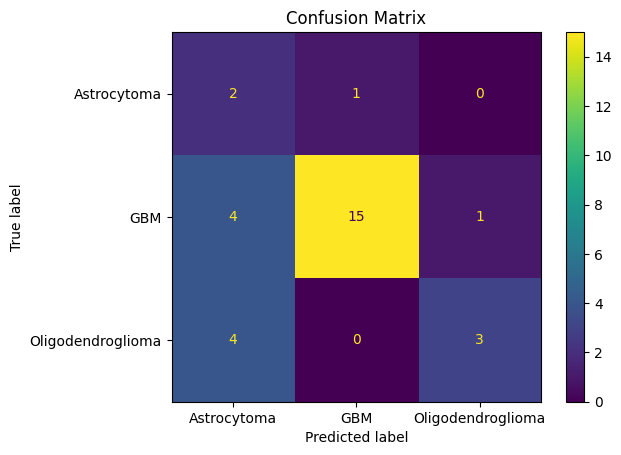

Classification Report:
                   precision    recall  f1-score   support

      Astrocytoma       0.20      0.67      0.31         3
              GBM       0.94      0.75      0.83        20
Oligodendroglioma       0.75      0.43      0.55         7

         accuracy                           0.67        30
        macro avg       0.63      0.62      0.56        30
     weighted avg       0.82      0.67      0.71        30

Accuracy: 0.6666666666666666
Cross-validation Accuracy: 0.95



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from joblib import dump
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df_encoded and target y already defined

# Identifying non-numeric columns and encoding them or removing identifiers
non_numeric_columns = df_encoded.select_dtypes(include=['object']).columns
print("Non-numeric columns identified for removal or encoding:", non_numeric_columns)
# Removing identifier columns, adjust as necessary for your dataset
df_encoded = df_encoded.drop(non_numeric_columns, axis=1)

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Set up the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf', 'poly']
}

# Create a GridSearchCV object with custom class weights
grid_search = GridSearchCV(SVC(class_weight='balanced', random_state=42), param_grid, cv=5, verbose=2, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_resampled)

# Best model found by grid search
best_svm = grid_search.best_estimator_

# Cross-validation on the training set
cross_val_score_result = cross_val_score(best_svm, X_train_scaled, y_train_resampled, cv=5)
cross_val_mean = np.mean(cross_val_score_result)

# Save the trained model to a file
model_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/SVM_modelgrid.joblib'
dump(best_svm, model_path)

# Predicting the Test set results using the best model
y_pred = best_svm.predict(X_test_scaled)

# Generating and printing classification report and accuracy
report = classification_report(y_test, y_pred, zero_division=0)
accuracy = accuracy_score(y_test, y_pred)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot()
plt.title('Confusion Matrix')
plt.show()

# Print results
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy}")
print(f"Cross-validation Accuracy: {cross_val_mean:.2f}\n")



**SMOTE**: It balances the dataset by synthesizing new samples for the minority class.

**Grid Search with Cross-Validation:**  It searches for the best hyperparameters to optimize the SVM.

**Model Saving:** Each model is saved to your specified path, which can be useful for deploying models or further evaluation later.

**Confusion Matrix:** Visualizes the performance of the SVM model for each disease type, showing true positives, true negatives, false positives, and false negatives.

**Cross-validation:** Provides a more robust estimate of model performance by running multiple validations across different subsets of the dataset, ensuring the model's stability and generalizability. It computes the mean accuracy from the cross-validation to help assess the model's effectiveness across different parts of the data.

### SVM with RandomisedSearchCV

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END C=30.406190809066008, class_weight=balanced, gamma=0.3297249792975182, kernel=linear; total time=   0.0s
[CV] END C=30.406190809066008, class_weight=balanced, gamma=0.3297249792975182, kernel=linear; total time=   0.0s
[CV] END C=30.406190809066008, class_weight=balanced, gamma=0.3297249792975182, kernel=linear; total time=   0.0s
[CV] END C=30.406190809066008, class_weight=balanced, gamma=0.3297249792975182, kernel=linear; total time=   0.0s
[CV] END C=30.406190809066008, class_weight=balanced, gamma=0.3297249792975182, kernel=linear; total time=   0.0s
[CV] END C=106.38944703484205, class_weight=balanced, gamma=0.3297249792975182, kernel=linear; total time=   0.0s
[CV] END C=106.38944703484205, class_weight=balanced, gamma=0.3297249792975182, kernel=linear; total time=   0.0s
[CV] END C=106.38944703484205, class_weight=balanced, gamma=0.3297249792975182, kernel=linear; total time=   0.0s
[CV] END C=106.3894470348

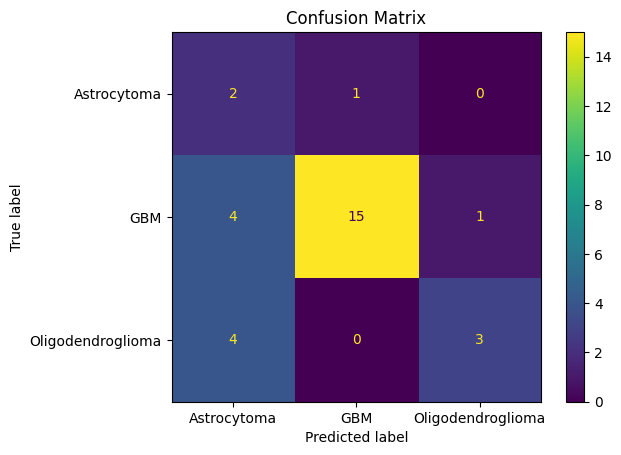

Classification Report:
                   precision    recall  f1-score   support

      Astrocytoma       0.20      0.67      0.31         3
              GBM       0.94      0.75      0.83        20
Oligodendroglioma       0.75      0.43      0.55         7

         accuracy                           0.67        30
        macro avg       0.63      0.62      0.56        30
     weighted avg       0.82      0.67      0.71        30

Accuracy: 0.6666666666666666
Cross-validation Accuracy: 0.95



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from joblib import dump
import matplotlib.pyplot as plt
import scipy.stats as stats

# Assuming you have a DataFrame df_encoded and target y already defined

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Set up the parameter grid to search
param_dist = {
    'C': stats.expon(scale=100),
    'gamma': ['scale', 'auto'] + stats.expon(scale=0.5).rvs(size=10).tolist(),
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': ['balanced', None]
}

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(SVC(random_state=42), param_distributions=param_dist, n_iter=100, cv=5, verbose=2, scoring='accuracy')
random_search.fit(X_train_scaled, y_train_resampled)

# Best model found by random search
best_svm = random_search.best_estimator_

# Cross-validation on the training set
cross_val_score_result = cross_val_score(best_svm, X_train_scaled, y_train_resampled, cv=5)
cross_val_mean = np.mean(cross_val_score_result)

# Save the trained model to a file
model_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/SVM_model.joblib'
dump(best_svm, model_path)

# Predicting the Test set results using the best model
y_pred = best_svm.predict(X_test_scaled)

# Generating and printing classification report and accuracy
report = classification_report(y_test, y_pred, zero_division=0)
accuracy = accuracy_score(y_test, y_pred)

# Calculate and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot()
plt.title('Confusion Matrix')
plt.show()

# Print results
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy}")
print(f"Cross-validation Accuracy: {cross_val_mean:.2f}\n")


### SVM with AdamBooster

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Classification Report:
                   precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         3
              GBM       0.90      0.95      0.93        20
Oligodendroglioma       0.60      0.43      0.50         7

         accuracy                           0.73        30
        macro avg       0.50      0.46      0.48        30
     weighted avg       0.74      0.73      0.73        30

Accuracy: 0.7333333333333333


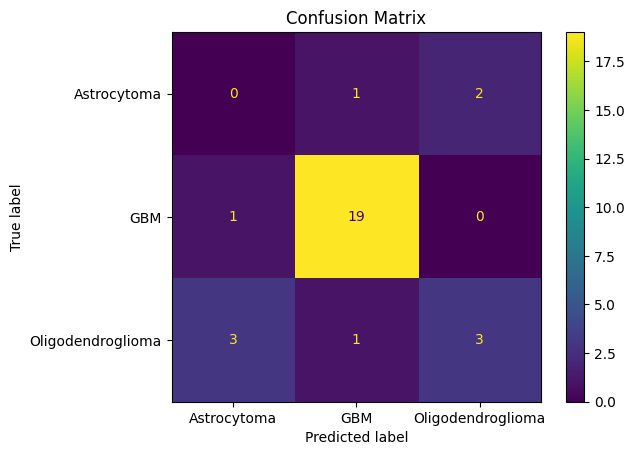

Cross-validation Accuracy: 0.89



['/content/drive/MyDrive/7009_Final_Project_Data/Models/AdaBoost_SVM_model.joblib']

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from joblib import dump
import matplotlib.pyplot as plt

# Assuming X and y are already defined, with y being a Series and not a DataFrame

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Base SVM Classifier for AdaBoost
base_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

# AdaBoost with SVM as the base classifier
ada_boost = AdaBoostClassifier(base_estimator=base_svm, n_estimators=50, random_state=42)
ada_boost.fit(X_train_scaled, y_train_resampled)

# Cross-validation on the training set
cross_val_score_result = cross_val_score(ada_boost, X_train_scaled, y_train_resampled, cv=5)
cross_val_mean = np.mean(cross_val_score_result)

# Predicting the Test set results using AdaBoost
y_pred = ada_boost.predict(X_test_scaled)

# Evaluating the model
report = classification_report(y_test, y_pred, zero_division=0)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display results
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy}")
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot()
plt.title('Confusion Matrix')
plt.show()
print(f"Cross-validation Accuracy: {cross_val_mean:.2f}\n")

# Save the trained model
model_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/AdaBoost_SVM_model.joblib'
dump(ada_boost, model_path)


In [ ]:
import pandas as pd

# Set max rows and max columns to None to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# You can also set these to a high number if you prefer not to go unlimited
# For example, to display up to 50


In [ ]:
X_train.head()

,diagnostics_Image-original_Maximum,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Mask-original_VolumeNum,diagnostics_Mask-original_VoxelNum,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,original_firstorder_Mean,original_firstorder_MeanAbsoluteDeviation,original_firstorder_Median,original_firstorder_Minimum,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,original_glcm_Idm,original_glcm_Idmn,original_glcm_Idn,original_glcm_Imc1,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares,original_gldm_DependenceEntropy,original_gldm_DependenceNonUniformity,original_gldm_DependenceNonUniformityNormalized,original_gldm_DependenceVariance,original_gldm_GrayLevelNonUniformity,original_gldm_GrayLevelVariance,original_gldm_HighGrayLevelEmphasis,original_gldm_LargeDependenceEmphasis,original_gldm_LargeDependenceHighGrayLevelEmphasis,original_gldm_LargeDependenceLowGrayLevelEmphasis,original_gldm_LowGrayLevelEmphasis,original_gldm_SmallDependenceEmphasis,original_gldm_SmallDependenceHighGrayLevelEmphasis,original_gldm_SmallDependenceLowGrayLevelEmphasis,original_glrlm_GrayLevelNonUniformity,original_glrlm_GrayLevelNonUniformityNormalized,original_glrlm_GrayLevelVariance,original_glrlm_HighGrayLevelRunEmphasis,original_glrlm_LongRunEmphasis,original_glrlm_LongRunHighGrayLevelEmphasis,original_glrlm_LongRunLowGrayLevelEmphasis,original_glrlm_LowGrayLevelRunEmphasis,original_glrlm_RunEntropy,original_glrlm_RunLengthNonUniformity,original_glrlm_RunLengthNonUniformityNormalized,original_glrlm_RunPercentage,original_glrlm_RunVariance,original_glrlm_ShortRunEmphasis,original_glrlm_ShortRunHighGrayLevelEmphasis,original_glrlm_ShortRunLowGrayLevelEmphasis,original_glszm_GrayLevelNonUniformity,original_glszm_GrayLevelNonUniformityNormalized,original_glszm_GrayLevelVariance,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_LowGrayLevelZoneEmphasis,original_glszm_SizeZoneNonUniformity,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
22,702.0,41.421197,0.0,88,15826,222.0,251.0,8.890622e+08,1.142845,15.0,5.665546,329.0,236.706559,9.220351,237.0,193.0,136.0,6.319157,237.017543,0.550576,8.890622e+08,0.577207,147.320565,8.873863,2.810496e+00,-0.063506,0.763713,0.203737,0.578101,0.201493,0.725855,0.161807,0.899618,0.899478,0.995931,0.

Classification Report:
                   precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         3
              GBM       0.64      0.80      0.71        20
Oligodendroglioma       0.00      0.00      0.00         7

         accuracy                           0.53        30
        macro avg       0.21      0.27      0.24        30
     weighted avg       0.43      0.53      0.47        30

Accuracy: 0.5333333333333333


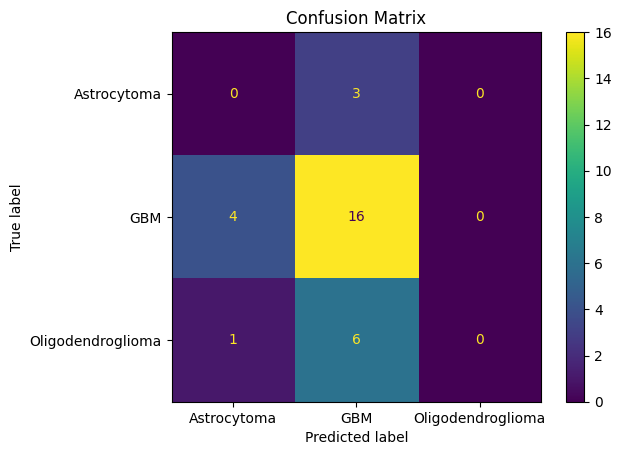

['/content/drive/MyDrive/7009_Final_Project_Data/Models/model.joblib']

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier, IsolationForest
from imblearn.over_sampling import SMOTE
from joblib import dump
import numpy as np
import matplotlib.pyplot as plt

# Assuming df_encoded is your feature set and y is your target Series
# Choose the approach based on the presence of a specific disease type in y

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

# Check if we are working with a specific condition (e.g., anomaly detection for a specific disease)
# Here we need to clarify how to determine if we're dealing with 'Disease_Type_Astrocytoma' or others
if 'Astrocytoma' in np.unique(y_train):  # Example condition to apply anomaly detection
    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Isolation Forest for anomaly detection
    iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
    iso_forest.fit(X_train_scaled)

    # Predicting the Test set results using Isolation Forest
    y_pred = iso_forest.predict(X_test_scaled)
    y_pred = np.where(y_pred == 1, y_train.mode()[0], 'Astrocytoma')  # Adjusting predictions

else:
    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)

    # Base SVM Classifier for AdaBoost
    base_svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)

    # AdaBoost with SVM as the base classifier
    ada_boost = AdaBoostClassifier(base_estimator=base_svm, n_estimators=50, random_state=42)
    ada_boost.fit(X_train_scaled, y_train_resampled)

    # Predicting the Test set results using AdaBoost
    y_pred = ada_boost.predict(X_test_scaled)

# Evaluating the model
report = classification_report(y_test, y_pred, zero_division=0)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Display results
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy}")
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot()
plt.title('Confusion Matrix')
plt.show()

# Optionally save the trained model
model_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/model.joblib'
dump(ada_boost if 'Astrocytoma' not in np.unique(y_train) else iso_forest, model_path)


Classification Report:
                   precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         3
              GBM       0.64      0.80      0.71        20
Oligodendroglioma       0.00      0.00      0.00         7

         accuracy                           0.53        30
        macro avg       0.21      0.27      0.24        30
     weighted avg       0.43      0.53      0.47        30

Accuracy: 0.5333333333333333


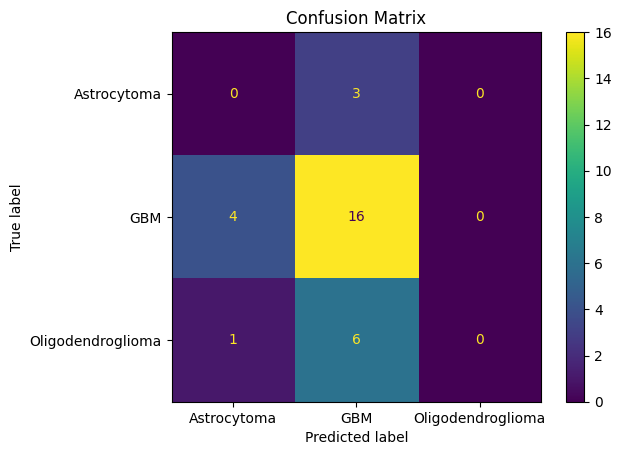

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Assuming the required libraries are imported and models are defined

# Convert y to string type if it contains numeric labels
y = y.astype(str)

# Re-split the dataset after converting labels
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

# For Isolation Forest or any model with a non-traditional output:
if 'Astrocytoma' in y.unique():
    # Isolation Forest predicts the test set results
    y_pred = iso_forest.predict(X_test_scaled)
    y_pred = np.where(y_pred == 1, y_train.mode()[0], 'Astrocytoma')  # Adjusting predictions based on the mode
else:
    # Traditional classifiers like AdaBoost + SVM
    y_pred = ada_boost.predict(X_test_scaled)

# Fixing labels for the confusion matrix and classification report
labels = np.unique(y)  # Ensuring all possible labels are included
labels.sort()  # Sorting labels for consistent ordering

# Evaluating the model
report = classification_report(y_test, y_pred, labels=labels, zero_division=0)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Display results
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy}")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.title('Confusion Matrix')
plt.show()


(119, 112)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

Classification Report:
                   precision    recall  f1-score   support

      Astrocytoma       0.20      0.33      0.25         3
              GBM       0.90      0.95      0.93        20
Oligodendroglioma       0.75      0.43      0.55         7

         accuracy                           0.77        30
        macro avg       0.62      0.57      0.57        30
     weighted avg       0.80      0.77      0.77        30

Accuracy: 0.7666666666666667


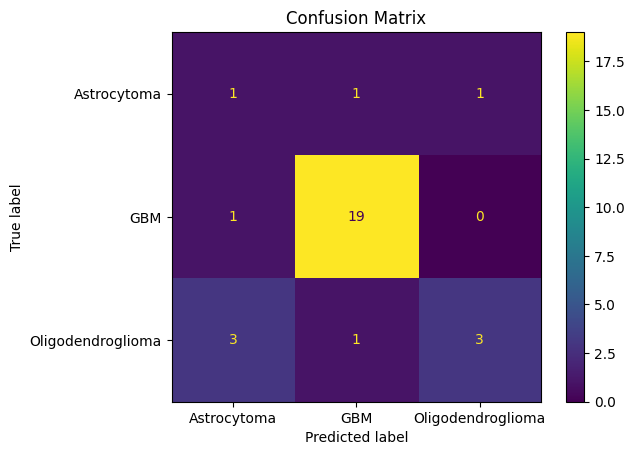

Cross-validation Accuracy: 0.86


['/content/drive/MyDrive/7009_Final_Project_Data/Models/stacking_classifier_model.joblib']

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from joblib import dump
import numpy as np
import matplotlib.pyplot as plt

# Supondo que 'df_encoded' é o seu DataFrame e 'y' a série de rótulos

# Divisão do conjunto de dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)
print(X_train.shape)
# Escalonamento de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicação de SMOTE para balancear o conjunto de dados
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Definição dos estimadores base
estimators = [
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)),
    ('ada_boost', AdaBoostClassifier(base_estimator=SVC(probability=True, class_weight='balanced', random_state=42), random_state=42, n_estimators=50))
]

# Classificador Stacking com regressão logística como estimador final
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stack_clf.fit(X_train_resampled, y_train_resampled)

# Predição dos resultados do conjunto de teste usando o classificador stacking
y_pred = stack_clf.predict(X_test_scaled)

# Avaliação e armazenamento dos resultados
report = classification_report(y_test, y_pred, zero_division=0)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Validação cruzada para avaliação do modelo
cross_val_score_result = cross_val_score(stack_clf, X_train_resampled, y_train_resampled, cv=5)
cross_val_mean = np.mean(cross_val_score_result)

# Exibição dos resultados
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy}")
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot()
plt.title('Confusion Matrix')
plt.show()
print(f"Cross-validation Accuracy: {cross_val_mean:.2f}")

# Salvamento do modelo treinado
model_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/stacking_classifier_model.joblib'
dump(stack_clf, model_path)



In [ ]:
'''from sklearn.ensemble import StackingClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from joblib import dump
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a DataFrame df_encoded and a single target Series y already defined

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Define the base estimators
estimators = [
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)),
    ('ada_boost', AdaBoostClassifier(base_estimator=SVC(probability=True, class_weight='balanced', random_state=42), random_state=42, n_estimators=50))
]

# Stacking classifier with logistic regression as a final estimator
stack_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5)
stack_clf.fit(X_train_resampled, y_train_resampled)

# Predicting the Test set results using the stacking classifier
y_pred = stack_clf.predict(X_test_scaled)

# Evaluate and store results
report = classification_report(y_test, y_pred, zero_division=0)
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Cross-validation to evaluate model
cross_val_score_result = cross_val_score(stack_clf, X_train_resampled, y_train_resampled, cv=5)
cross_val_mean = np.mean(cross_val_score_result)

# Print results
print("Classification Report:")
print(report)
print(f"Accuracy: {accuracy}")
ConfusionMatrixDisplay(cm, display_labels=np.unique(y)).plot()
plt.title('Confusion Matrix')
plt.show()
print(f"Cross-validation Accuracy: {cross_val_mean:.2f}")

# Save the trained model
model_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/stacking_classifier_model.joblib'
dump(stack_clf, model_path)
'''

'from sklearn.ensemble import StackingClassifier, IsolationForest\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.model_selection import train_test_split, cross_val_score\nfrom sklearn.preprocessing import StandardScaler\nfrom sklearn.svm import SVC\nfrom sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay\nfrom sklearn.ensemble import AdaBoostClassifier\nfrom imblearn.over_sampling import SMOTE\nfrom joblib import dump\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Assuming you have a DataFrame df_encoded and a single target Series y already defined\n\n# Splitting the dataset into the training set and test set\nX_train, X_test, y_train, y_test = train_test_split(df_encoded, y, test_size=0.2, random_state=42)\n\n# Feature Scaling\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_test_scaled = scaler.transform(X_test)\n\n# Apply SMOTE to balance the dataset\nsmote = SMOTE(random_

## XGBoost

Model saved successfully at /content/drive/MyDrive/7009_Final_Project_Data/Models/xgb_model.joblib


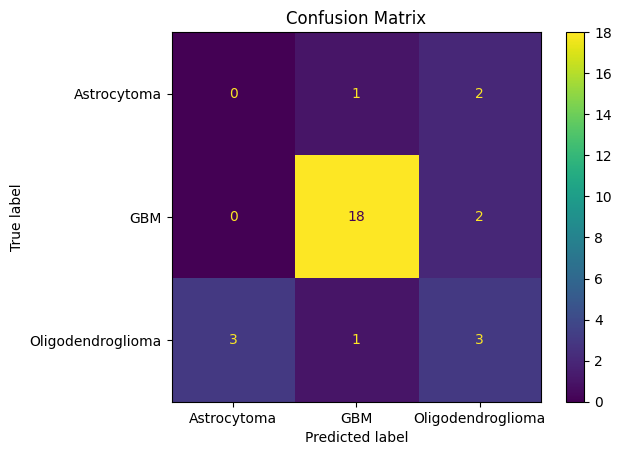

Classification Report:
                    precision    recall  f1-score   support

      Astrocytoma       0.00      0.00      0.00         3
              GBM       0.90      0.90      0.90        20
Oligodendroglioma       0.43      0.43      0.43         7

         accuracy                           0.70        30
        macro avg       0.44      0.44      0.44        30
     weighted avg       0.70      0.70      0.70        30

Accuracy: 0.7
Cross-validation accuracy: 0.8124137931034483

   Model Accuracy  Cross-Validation Accuracy  \
0             0.7                   0.812414   

                               Classification Report  
0                     precision    recall  f1-sco...  


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder
from joblib import dump
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'X' is your feature DataFrame and 'y' is your target Series

# Encode categorical class labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Create and fit the model
model = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Save the model
model_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/xgb_model.joblib'  # Adjust path as needed
dump(model, model_path)
print(f"Model saved successfully at {model_path}")

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# Decode predictions for reporting and confusion matrix
y_test_decoded = label_encoder.inverse_transform(y_test)
y_pred_decoded = label_encoder.inverse_transform(y_pred)

# Store the confusion matrix and display it
cm = confusion_matrix(y_test_decoded, y_pred_decoded)
display = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
display.plot()
plt.title('Confusion Matrix')
plt.show()

# Generate and store the classification report
report = classification_report(y_test_decoded, y_pred_decoded, zero_division=0)
print("Classification Report:\n", report)

# Perform cross-validation
cv_scores = cross_val_score(model, X, y_encoded, cv=5)
cross_val_mean = cv_scores.mean()

print(f"Accuracy: {accuracy}")
print(f"Cross-validation accuracy: {cross_val_mean}\n")

# Collecting results into a DataFrame for easier analysis and comparison
results_summary = {
    'Model Accuracy': [accuracy],
    'Cross-Validation Accuracy': [cross_val_mean],
    'Classification Report': [report]
}

results_df = pd.DataFrame(results_summary)
print(results_df)


# Step 3: Model Application to Step 1 Features

In [ ]:
'''# Path to the CSV file
new_features_path = '/content/drive/MyDrive/7009_Final_Project_Data/Project_features_Step1_Aizhan_NEW.csv'

# Load the data into a DataFrame
new_features_df = pd.read_csv(new_features_path)

# Display the first few rows of the DataFrame
new_features_df.head()
new_features_df.tail()'''

"# Path to the CSV file\nnew_features_path = '/content/drive/MyDrive/7009_Final_Project_Data/Project_features_Step1_Aizhan_NEW.csv'\n\n# Load the data into a DataFrame\nnew_features_df = pd.read_csv(new_features_path)\n\n# Display the first few rows of the DataFrame\nnew_features_df.head()\nnew_features_df.tail()"

In [ ]:
'''# Load clinical data from a text file
file_path = '/content/drive/MyDrive/7009_Final_Project_Data/Rembrandt_Clinical_ground_truth_64set.txt'
clinical_data_df = pd.read_csv(file_path, sep="\t")  # Adjust separator if necessary

# One-hot encode the 'Disease_Type' column
#true_labels_encoded = pd.get_dummies(clinical_data_df['DISEASE_TYPE'])'''

'# Load clinical data from a text file\nfile_path = \'/content/drive/MyDrive/7009_Final_Project_Data/Rembrandt_Clinical_ground_truth_64set.txt\'\nclinical_data_df = pd.read_csv(file_path, sep="\t")  # Adjust separator if necessary\n\n# One-hot encode the \'Disease_Type\' column\n#true_labels_encoded = pd.get_dummies(clinical_data_df[\'DISEASE_TYPE\'])'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from joblib import load
import matplotlib.pyplot as plt

# Load the clinical data
clinical_data_path = '/content/drive/MyDrive/7009_Final_Project_Data/Rembrandt_Clinical_ground_truth_64set.txt'
clinical_data_df = pd.read_csv(clinical_data_path, sep="\t", usecols=['DISEASE_TYPE'])

# Remove rows where 'DISEASE_TYPE' is NaN
clinical_data_df = clinical_data_df.dropna(subset=['DISEASE_TYPE'])

# Load the feature data
features_path = '/content/drive/MyDrive/7009_Final_Project_Data/Project_features_Step1_Aizhan_NEW.csv'
features_df = pd.read_csv(features_path)

# Drop rows where the index does not match with clinical_data_df (alignment based on index)
features_df = features_df.loc[clinical_data_df.index]

# Load the scaler and model
scaler = load('/content/drive/MyDrive/7009_Final_Project_Data/Models/scaler.joblib')
model = load('/content/drive/MyDrive/7009_Final_Project_Data/Models/xgb_model.joblib')


In [ ]:
# Extract feature names from the scaler
required_features = scaler.feature_names_in_

# Ensure new_features_df contains only these required features
new_features_df = features_df[required_features]

# Scale the features
X_new_scaled = scaler.transform(new_features_df)


Classification Report:
                   precision    recall  f1-score   support

      ASTROCYTOMA       0.55      0.21      0.31        28
              GBM       0.34      0.89      0.49        18
OLIGODENDROGLIOMA       0.00      0.00      0.00        12

         accuracy                           0.38        58
        macro avg       0.30      0.37      0.27        58
     weighted avg       0.37      0.38      0.30        58



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


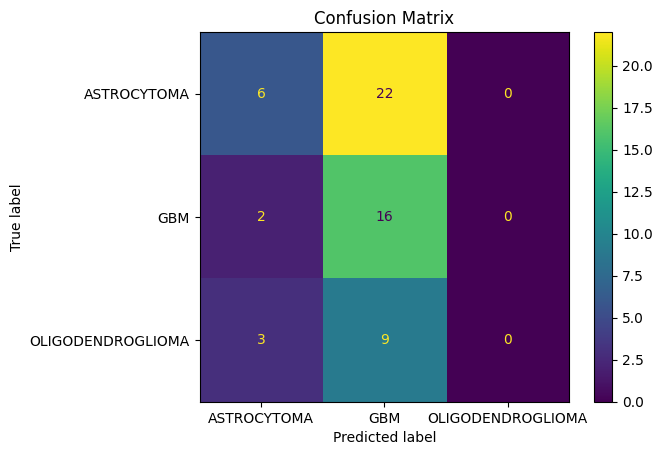

Accuracy: 0.3793103448275862


In [ ]:
# Predict using the loaded model
predictions = model.predict(X_new_scaled)

# Decode predictions if necessary (assuming model outputs numeric labels directly related to diseases)
label_encoder = LabelEncoder().fit(clinical_data_df['DISEASE_TYPE'])
predictions_labels = label_encoder.inverse_transform(predictions)

# Evaluate predictions
true_labels = clinical_data_df['DISEASE_TYPE'].values  # Ensuring it's an array for evaluation

print("Classification Report:")
print(classification_report(true_labels, predictions_labels))

cm = confusion_matrix(true_labels, predictions_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(true_labels, predictions_labels)
print("Accuracy:", accuracy)


In [ ]:
'''#code fixed for proper use of features

import pandas as pd
from joblib import load
from sklearn.metrics import accuracy_score

# List of unseen columns to be removed
unseen_columns = [
    'Unnamed: 0', 'diagnostics_Configuration_Settings', 'diagnostics_Versions_PyWavelet',
    'diagnostics_Mask-original_Size', 'diagnostics_Image-original_Dimensionality',
    'diagnostics_Image-original_Hash', 'diagnostics_Versions_SimpleITK', 'diagnostics_Image-original_Size',
    'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Python', 'diagnostics_Mask-original_CenterOfMassIndex',
    'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_BoundingBox',
    'diagnostics_Mask-original_CenterOfMass', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Spacing',
    'diagnostics_Versions_Numpy'
]

# Removing unseen columns from new_features_df
new_features_df = new_features_df.drop(columns=unseen_columns, errors='ignore')'''

"#code fixed for proper use of features\n\nimport pandas as pd\nfrom joblib import load\nfrom sklearn.metrics import accuracy_score\n\n# List of unseen columns to be removed\nunseen_columns = [\n    'Unnamed: 0', 'diagnostics_Configuration_Settings', 'diagnostics_Versions_PyWavelet',\n    'diagnostics_Mask-original_Size', 'diagnostics_Image-original_Dimensionality',\n    'diagnostics_Image-original_Hash', 'diagnostics_Versions_SimpleITK', 'diagnostics_Image-original_Size',\n    'diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Python', 'diagnostics_Mask-original_CenterOfMassIndex',\n    'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_BoundingBox',\n    'diagnostics_Mask-original_CenterOfMass', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Spacing',\n    'diagnostics_Versions_Numpy'\n]\n\n# Removing unseen columns from new_features_df\nnew_features_df = new_features_df.drop(columns=unseen_columns, err

In [ ]:
'''# Check if all required features are present
required_features = ['Gender', 'Race', 'Disease_Type_Astrocytoma', 'Disease_Type_GBM', 'Disease_Type_Oligodendroglioma'] + list(correct_feature_names)
missing_features = [f for f in required_features if f not in new_features_df.columns]

# If missing, you can choose to add them with a default value or handle the missing case
for feature in missing_features:
    # Add missing features with a default value or based on domain knowledge
    # Example: adding a categorical feature with the most common category or a median/mean
    if feature in ['Gender', 'Race']:
        new_features_df[feature] = 'Unknown'  # Adjust based on appropriate handling
    else:
        new_features_df[feature] = 0  # For binary features like 'Disease_Type_...', assuming False as default

# Now reorder and use only the features used during model training
new_features_df = new_features_df[correct_feature_names]
'''

"# Check if all required features are present\nrequired_features = ['Gender', 'Race', 'Disease_Type_Astrocytoma', 'Disease_Type_GBM', 'Disease_Type_Oligodendroglioma'] + list(correct_feature_names)\nmissing_features = [f for f in required_features if f not in new_features_df.columns]\n\n# If missing, you can choose to add them with a default value or handle the missing case\nfor feature in missing_features:\n    # Add missing features with a default value or based on domain knowledge\n    # Example: adding a categorical feature with the most common category or a median/mean\n    if feature in ['Gender', 'Race']:\n        new_features_df[feature] = 'Unknown'  # Adjust based on appropriate handling\n    else:\n        new_features_df[feature] = 0  # For binary features like 'Disease_Type_...', assuming False as default\n\n# Now reorder and use only the features used during model training\nnew_features_df = new_features_df[correct_feature_names]\n"

In [ ]:
'''# Assuming you know the correct order of features or can obtain it from the scaler
correct_feature_names = scaler.feature_names_in_  # This will work if your scaler saves feature names

# Reorder new_features_df to match training features
new_features_df = new_features_df[correct_feature_names]

# Now you can safely scale the data
X_new_scaled = scaler.transform(new_features_df)'''


'# Assuming you know the correct order of features or can obtain it from the scaler\ncorrect_feature_names = scaler.feature_names_in_  # This will work if your scaler saves feature names\n\n# Reorder new_features_df to match training features\nnew_features_df = new_features_df[correct_feature_names]\n\n# Now you can safely scale the data\nX_new_scaled = scaler.transform(new_features_df)'

In [ ]:
'''# Load the model
model = load('/content/drive/MyDrive/7009_Final_Project_Data/Models/xgb_model.joblib')

# Make predictions
predictions = model.predict(X_new_scaled)

# If you have the ground truth labels in clinical_data_df['DISEASE_TYPE']
true_labels = clinical_data_df['DISEASE_TYPE']

# Calculate accuracy and display classification report
from sklearn.metrics import classification_report, confusion_matrix

accuracy = accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

# Optionally, display confusion matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(true_labels))
disp.plot()
plt.title('Confusion Matrix')
plt.show()'''


'# Load the model\nmodel = load(\'/content/drive/MyDrive/7009_Final_Project_Data/Models/xgb_model.joblib\')\n\n# Make predictions\npredictions = model.predict(X_new_scaled)\n\n# If you have the ground truth labels in clinical_data_df[\'DISEASE_TYPE\']\ntrue_labels = clinical_data_df[\'DISEASE_TYPE\']\n\n# Calculate accuracy and display classification report\nfrom sklearn.metrics import classification_report, confusion_matrix\n\naccuracy = accuracy_score(true_labels, predictions)\nreport = classification_report(true_labels, predictions)\n\nprint("Accuracy:", accuracy)\nprint("Classification Report:")\nprint(report)\n\n# Optionally, display confusion matrix\ncm = confusion_matrix(true_labels, predictions)\ndisp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(true_labels))\ndisp.plot()\nplt.title(\'Confusion Matrix\')\nplt.show()'

In [ ]:
# Load features data
features_path = '/content/drive/MyDrive/7009_Final_Project_Data/Project_features_Step1_Aizhan_NEW.csv'
features_df = pd.read_csv(features_path)

# Display basic information about the features data
print("Features Data Information:")
print(features_df.info())
print("\nFirst few rows of the features data:")
print(features_df.head())

# Load clinical data
clinical_data_path = '/content/drive/MyDrive/7009_Final_Project_Data/Rembrandt_Clinical_ground_truth_64set.txt'
clinical_data_df = pd.read_csv(clinical_data_path, sep="\t", usecols=['DISEASE_TYPE'])

# Display basic information about the clinical data
print("\nClinical Data Information:")
print(clinical_data_df.info())
print("\nFirst few rows of the clinical data:")
print(clinical_data_df.head())


Features Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Columns: 130 entries, Unnamed: 0 to original_ngtdm_Strength
dtypes: float64(110), int64(2), object(18)
memory usage: 65.1+ KB
None

First few rows of the features data:
          Unnamed: 0 diagnostics_Versions_PyRadiomics  \
0  HF1409_1994.09.23                           v3.0.1   
1  HF1458_1994.12.28                           v3.0.1   
2  HF1381_1994.08.12                           v3.0.1   
3  HF1433_1994.11.11                           v3.0.1   
4  HF1318_1994.04.23                           v3.0.1   

  diagnostics_Versions_Numpy diagnostics_Versions_SimpleITK  \
0                     1.25.2                          2.3.1   
1                     1.25.2                          2.3.1   
2                     1.25.2                          2.3.1   
3                     1.25.2                          2.3.1   
4                     1.25.2                          2.3.1   

  diagnostic

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from joblib import load
import matplotlib.pyplot as plt


# Define model paths
model_files = {
    'xg': '/content/drive/MyDrive/7009_Final_Project_Data/Models/xgb_model.joblib',
    'ada': '/content/drive/MyDrive/7009_Final_Project_Data/Models/AdaBoost_SVM_model.joblib',
    'stacking': '/content/drive/MyDrive/7009_Final_Project_Data/Models/stacking_classifier_model.joblib'
}

# Load models
models = {disease: load(path) for disease, path in model_files.items()}

# Load features data
features_path = '/content/drive/MyDrive/7009_Final_Project_Data/Project_features_Step1_Aizhan_NEW.csv'
features_df = pd.read_csv(features_path)

# Assuming that the first row contains column names and all necessary features are included
# If you need to drop any unnecessary columns, do it here

# Load scaler
scaler_path = '/content/drive/MyDrive/7009_Final_Project_Data/Models/scaler.joblib'
scaler = load(scaler_path)

# Assuming the scaler expects certain columns, you need to ensure they match:
required_features = scaler.feature_names_in_  # If this attribute is available
features_df = features_df[required_features]  # Align columns

# Scale the features
X_scaled = scaler.transform(features_df)

# Load clinical data
clinical_data_path = '/content/drive/MyDrive/7009_Final_Project_Data/Rembrandt_Clinical_ground_truth_64set.txt'
clinical_data_df = pd.read_csv(clinical_data_path, sep="\t", usecols=['DISEASE_TYPE'])

# Filter NaNs or handle them appropriately
clinical_data_df.dropna(subset=['DISEASE_TYPE'], inplace=True)

# Predict using the loaded models
# Predict using the loaded models
for disease, model in models.items():
    predictions = model.predict(X_scaled)
    predictions = [str(pred) for pred in predictions]  # Convert predictions to strings
    print(f"Predictions for {disease} processed successfully.")

    true_labels = clinical_data_df['DISEASE_TYPE']  # Assuming this contains the true labels

    # Generate and display classification report and confusion matrix
    print("Classification Report for", disease)
    print(classification_report(true_labels, predictions))

    # ...


    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {disease}')
    plt.show()

    # Calculate and display accuracy
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Accuracy for {disease}: {accuracy}")


Predictions for xg processed successfully.
Classification Report for xg


ValueError: Found input variables with inconsistent numbers of samples: [58, 64]

In [ ]:
from sklearn.metrics import classification_report

# Assuming true_labels and predictions are your variables containing the labels and predictions respectively

# Check the lengths of true labels and predictions
print("Length of true labels:", len(true_labels))
print("Length of predictions:", len(predictions))

# If there is a mismatch in lengths, you need to align the data
# For example, you can truncate the longer list to match the length of the shorter one
min_length = min(len(true_labels), len(predictions))
true_labels = true_labels[:min_length]
predictions = predictions[:min_length]

# Now, both true labels and predictions have the same length
# You can generate the classification report
print("Classification Report for GBM")
print(classification_report(true_labels, predictions))


In [ ]:
from joblib import load
import pandas as pd
from sklearn.metrics import accuracy_score

# Correct path and filenames according to your provided structure
model_files = {
    'GBM': 'xgb_model.joblib',  # Example, adjust according to which model you use for GBM
    'Astrocytoma': 'AdaBoost_SVM_model.joblib',  # Example, adjust as necessary
    'Oligodendroglioma': 'stacking_classifier_model.joblib'  # Example, adjust as necessary
}

# Assuming all models can use the same scaler, if they indeed need one
scaler = load('/content/drive/MyDrive/7009_Final_Project_Data/Models/scaler.joblib')  # Adjust if you have different scalers

models = {disease: load(f'/content/drive/MyDrive/7009_Final_Project_Data/Models/{filename}') for disease, filename in model_files.items()}

# Predict using the loaded models (assuming new_features_df is already defined and properly prepared)
predictions = {}
for disease, model in models.items():
    X_new_scaled = scaler.transform(new_features_df)  # Scale the new features
    predictions[disease] = model.predict(X_new_scaled)
    print(f"Predictions for {disease} processed successfully.")
# Assuming you have a DataFrame `clinical_data_df` that contains actual labels for the diseases
true_labels_encoded = pd.get_dummies(clinical_data_df['Disease_Type'])  # Adjust column name as necessary

# Calculate and print accuracy for each disease type
for disease in predictions:
    label_col = disease  # Ensure the label column matches the expected format in `true_labels_encoded`
    if label_col in true_labels_encoded.columns:
        accuracy = accuracy_score(true_labels_encoded[label_col], predictions[disease])
        print(f"Accuracy for {disease}: {accuracy}")
    else:
        print(f"No ground truth data available for {disease}.")


In [ ]:
#new code fixed for model usage

# Load scalers and models from joblib files

# Load scalers and models from joblib files
scalers = {disease: load(f'/content/drive/MyDrive/7009_Final_Project_Data/Models/scaler_Disease_Type_{disease}.joblib') for disease in ['GBM', 'Astrocytoma', 'Oligodendroglioma']}
models = {disease: load(f'/content/drive/MyDrive/7009_Final_Project_Data/Models/SVM1_Disease_Type_{disease}.joblib') for disease
          in ['GBM', 'Astrocytoma', 'Oligodendroglioma']}

# Adjusting new_features_df to match the feature order of the scaler
# Assuming 'GBM' scaler has the same feature order needed for all (you should verify or adjust if each disease has a different model/scaler)
required_feature_order = scalers['GBM'].feature_names_in_  # Get the order of features expected by the scaler

# Reorder new_features_df columns according to the required feature order
new_features_df = new_features_df[required_feature_order]

# Predict using the models
predictions = {}
for disease in models:
    scaler = scalers[disease]
    model = models[disease]
    X_new_scaled = scaler.transform(new_features_df)  # Apply scaler to the correctly ordered feature set
    predictions[disease] = model.predict(X_new_scaled)
    print(f"Predictions for {disease} processed successfully.")

# Assuming clinical_data_df has a 'Disease_Type' column that needs to be encoded
true_labels_encoded = pd.get_dummies(clinical_data_df['DISEASE_TYPE'])

# Calculate and print accuracy for each disease type
for disease in predictions:
    label_col = disease.upper()  # Assuming true labels are in uppercase
    if label_col in true_labels_encoded.columns:
        accuracy = accuracy_score(true_labels_encoded[label_col], predictions[disease])
        print(f"Accuracy for {disease}: {accuracy}")
    else:
        print(f"No ground truth data available for {disease}.")


# Step 4: Ground Truth

In [ ]:
import pandas as pd

# Path to the .txt file
file_path = '/content/drive/MyDrive/7009_Final_Project_Data/Rembrandt_Clinical_ground_truth_64set.txt'

# Load the data into a DataFrame assuming it's tab-separated
clinical_data_df = pd.read_csv(file_path, sep='\t')

# Display the first few rows of the DataFrame
clinical_data_df.head()

In [ ]:
import pandas as pd

# Displaying the shape of the dataset
print("Data shape:", clinical_data_df.shape)

# Checking for missing values
print("Missing values:", clinical_data_df.isnull().sum())

# Display descriptive statistics for the first three and last three columns
description = pd.concat([clinical_data_df.iloc[:, :3].describe(), clinical_data_df.iloc[:, -3:].describe()], axis=1)
print("Data description for selected columns:\n", description)

# Finding unique values in the 'DISEASE_TYPE' column
unique_disease_types = clinical_data_df['DISEASE_TYPE'].unique()
print("Unique values in DISEASE_TYPE:", unique_disease_types)

In [ ]:
clinical_data_encoded = pd.get_dummies(clinical_data_df, columns=['DISEASE_TYPE'], dummy_na=False)

# Drop any old disease type columns that are not needed
# For example, drop old columns if they were incorrectly named before
# clinical_data_encoded.drop(['old_disease_column1', 'old_disease_column2'], axis=1, inplace=True)

# Convert numeric 0s and 1s to boolean False and True
for col in clinical_data_encoded.columns:
    if 'Disease_Type_' in col:  # This ensures we're only converting disease type columns
        clinical_data_encoded[col] = clinical_data_encoded[col].astype(bool)

# Print the shape of the processed data
print("Processed data shape:", clinical_data_encoded.shape)

# Display the processed DataFrame
print(clinical_data_encoded.head())

In [ ]:
clinical_data_encoded.rename(columns={
    'DISEASE_TYPE_ASTROCYTOMA': 'Disease_Type_Astrocytoma',
    'DISEASE_TYPE_GBM': 'Disease_Type_GBM',
    'DISEASE_TYPE_OLIGODENDROGLIOMA': 'Disease_Type_Oligodendroglioma'
}, inplace=True)

# Convert numeric 0s and 1s to boolean False and True
for col in clinical_data_encoded.columns:
    if 'Disease_Type_' in col:
        clinical_data_encoded[col] = clinical_data_encoded[col].astype(bool)

# Display the updated DataFrame
print(clinical_data_encoded.head())

# Poor Models Try-out

## SVC

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np

# Initialize a dictionary to store the cross-validation results
cv_scores = {}

# Iterate over each disease type in the 'y' DataFrame
for disease in y.columns:
    print(f"Processing {disease}...")

    # Create a pipeline that includes scaling and the SVM classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='linear', C=1.0, random_state=42))
    ])

    # Define the cross-validation strategy
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation and store the scores
    scores = cross_val_score(pipeline, X, y[disease], cv=cv_strategy, scoring='accuracy', n_jobs=-1)

    # Store the mean accuracy and standard deviation
    cv_scores[disease] = (np.mean(scores), np.std(scores))

    # Output results
    print(f"{disease} - CV Mean Accuracy: {cv_scores[disease][0]:.4f}, Std Dev: {cv_scores[disease][1]:.4f}")

# Optionally, review all results stored in cv_scores
for disease, scores in cv_scores.items():
    print(f"{disease} - CV Mean Accuracy: {scores[0]:.4f}, Std Dev: {scores[1]:.4f}")


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd

# Dictionary to store models and feature importance
models = {}
feature_importances = {}

# Iterate over each disease type column in y
for disease in y.columns:
    print(f"Training SVM for {disease}...")

    # Splitting the dataset into the training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y[disease], test_size=0.2, random_state=42)

    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # SVM Classifier
    svm_model = SVC(kernel='linear', C=1.0, random_state=42)
    svm_model.fit(X_train_scaled, y_train)

    # Store the model
    models[disease] = svm_model

    # Extract coefficients and store feature importance
    if svm_model.coef_.shape[0] == 1:  # Binary classification case
        feature_importances[disease] = abs(svm_model.coef_[0])
    else:
        raise ValueError("Model coefficients not in expected binary format")

# Step 2: Identify Top 10 Features for Each Disease Based on Coefficients
top_features = {}

for disease, coefs in feature_importances.items():
    # Create a DataFrame of features and their importance
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': coefs
    })

    # Sort by importance and select top 10
    top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
    top_features[disease] = top_10_features
    print(f"Top 10 important features for {disease}:\n{top_10_features}\n")

## SVM for multiple-types of cancer

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline

# Create a pipeline that includes scaling and the SVM classifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', OneVsRestClassifier(SVC(kernel='linear', C=1.0, random_state=42)))
])

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Predict the Test set results
y_pred = pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
# Access the trained classifiers from the OneVsRestClassifier
classifiers = pipeline.named_steps['svm'].estimators_

# Assuming you have the same number of features across all classifiers, collect the absolute values of coefficients
import numpy as np

# Calculate the average importance of each feature across all binary classifiers
feature_importances = np.mean([np.abs(clf.coef_[0]) for clf in classifiers], axis=0)

# Create a DataFrame for visualization
import pandas as pd
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort features by importance
top_features = features_df.sort_values(by='Importance', ascending=False).head(10)
print(top_features)

## Neural Networks for Multi-Label Classification

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(y_train.shape[1], activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
model.evaluate(X_test_scaled, y_test)

In [ ]:
import matplotlib.pyplot as plt

# Plotting training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training and validation history
plot_history(history)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Make predictions
predictions = model.predict(X_test_scaled)

# Since predictions are in probabilities due to the sigmoid activation, we can use a threshold (e.g., 0.5) to convert them to binary outputs
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Evaluate predictions with additional metrics if necessary
from sklearn.metrics import classification_report, hamming_loss

print(classification_report(y_test, binary_predictions))
print("Hamming Loss:", hamming_loss(y_test, binary_predictions))


In [ ]:
# Extract first layer weights
first_layer_weights = model.layers[0].get_weights()[0]
first_layer_importance = np.mean(np.abs(first_layer_weights), axis=1)

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': first_layer_importance
}).sort_values(by='Importance', ascending=False)

# Display top 10 important features
print(importance_df.head(10))

## Random Forest

It splits the dataset into training and testing subsets, including all one-hot encoded columns as separate target variables.
It trains a Random Forest model for each binary classification task (each cancer type as a separate column).
It uses ROC AUC to evaluate the performance of each binary classifier.
It combines the predicted probabilities from each model to determine the most likely class for each sample.
It calculates the overall accuracy based on these combined predictions.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Performing 10-fold cross-validation
cv_results = cross_validate(rf_model, X, y, cv=10, scoring='accuracy', return_estimator=True)

# Displaying average accuracy
print("Average CV Accuracy:", np.mean(cv_results['test_score']))

# Feature importances from the Random Forest model (from the last fold for simplicity)
feature_importances = cv_results['estimator'][-1].feature_importances_

# Mapping feature names to their importances
feature_importance_dict = dict(zip(X.columns, feature_importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Displaying top 5-10 most important features
print("Top 10 feature importances:")
for feature, importance in sorted_features[:10]:
    print(f"{feature}: {importance}")


1.   diagnostics_Mask-original_VolumeNum: This feature, having the highest importance, represents the number of distinct volumes identified in the diagnostic mask of the image, indicating variability or complexity in the segmented regions which may be crucial for distinguishing between types of brain tumors.
2.   original_shape_SurfaceVolumeRatio: The ratio of surface area to volume in the imaging data, this metric is critical as it reflects the compactness of the tumor, with more irregular shapes often associated with more aggressive tumor types.
3.   original_shape_MeshVolume: This feature measures the total volume of the mesh (3D representation) of the tumor. Larger volumes can indicate more advanced stages of tumor growth or inherently larger tumor types.
4.   diagnostics_Mask-original_VoxelNum: The total number of voxels within the mask of the image, providing a direct measure of tumor size and potentially its growth rate, which are essential factors in medical diagnosis and treatment planning.
5.   original_shape_VoxelVolume: Similar to MeshVolume, this measures the volume covered by the tumor in terms of voxel units, directly impacting the assessment of tumor size and its spatial extent within the brain.
6.   original_ngtdm_Coarseness: A texture descriptor, coarseness quantifies the rate of spatial intensity variation, helping to characterize the texture of the tumor tissue, which can be indicative of different tissue types and tumor grades.
7.   original_shape_MinorAxisLength: This measures the shortest axis of the fitted ellipse (in 3D, ellipsoid) around the tumor. Shorter axes can indicate more rounded tumors, whereas longer ones might suggest elongated growth patterns.
8.   original_gldm_DependenceEntropy: This entropy measure from the Gray Level Dependence Matrix reflects the randomness in the dependence of gray levels within the image. High entropy values suggest more complexity in texture patterns, which might be characteristic of certain tumor types.
9.   original_glrlm_RunEntropy: Another entropy measure, but from the Gray Level Run Length Matrix, this feature captures the randomness in the lengths of consecutive pixel runs of similar intensity, providing insight into the texture's line-like structures and their arrangement.
10.   original_shape_Sphericity: Sphericity indicates how closely the shape of the tumor approaches that of a perfect sphere. Non-spherical shapes are common in malignant tumors due to their irregular growth patterns.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_classifier.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_score

# Performing cross-validation
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)
print(f"Average CV Accuracy: {cv_scores.mean()}")

In [ ]:
# Getting feature importances
feature_importances = rf_classifier.feature_importances_
feature_names = X.columns

# Creating a DataFrame for easier visualization
importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(importances_df.head(10))  # Print the top 10 features

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define the K-fold cross validator
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Prepare to collect the feature importance
feature_importances = np.zeros((num_folds, X.shape[1]))

# Loop over each fold
fold_idx = 0
accuracies = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize the OneVsRestClassifier with a DecisionTreeClassifier
    ovr_classifier = OneVsRestClassifier(DecisionTreeClassifier(random_state=42))
    ovr_classifier.fit(X_train, y_train)

    # Evaluate the classifier
    y_pred = ovr_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print(f"Fold {fold_idx+1} Accuracy: {accuracy}")

    # Aggregate feature importance
    for estimator in ovr_classifier.estimators_:
        feature_importances[fold_idx] += estimator.feature_importances_

    fold_idx += 1

# Average the feature importances and accuracies
mean_feature_importances = feature_importances.mean(axis=0) / num_folds
mean_accuracy = np.mean(accuracies)

# Sort and select top 10 features
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': mean_feature_importances
})
top_10_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importance from Decision Tree")
plt.bar(top_10_features['Feature'], top_10_features['Importance'], color='b')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

# Print overall mean accuracy and top 10 features
print(f"Mean CV Accuracy: {mean_accuracy}")
print(top_10_features)

### Applying GridSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

# Define the model
tree = DecisionTreeClassifier(random_state=42)
ovr = OneVsRestClassifier(tree)

# Define the parameter grid
param_grid = {
    'estimator__max_depth': [None, 10, 20, 30],
    'estimator__min_samples_split': [2, 10, 20],
    'estimator__min_samples_leaf': [1, 5, 10]
}

# Setup the grid search
grid_search = GridSearchCV(ovr, param_grid, cv=5, scoring='accuracy')

# Fit grid search
best_model = grid_search.fit(X, y)

# Print best parameters and best score
print("Best parameters:", best_model.best_params_)
print("Best score:", best_model.best_score_)


### RandomizedGridSearchCV

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import randint

# Define the model
tree = DecisionTreeClassifier(random_state=42)
ovr = OneVsRestClassifier(tree)

# Define the parameter distribution
param_dist = {
    'estimator__max_depth': [10, 20, 30, None],  # None means unlimited depth
    'estimator__min_samples_split': randint(2, 20),  # Random integers between 2 and 20
    'estimator__min_samples_leaf': randint(1, 10)   # Random integers between 1 and 10
}

# Setup the randomized search with cross-validation
random_search = RandomizedSearchCV(
    estimator=ovr,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,        # 5-fold cross-validation
    verbose=1,   # Controls the verbosity: the higher, the more messages
    random_state=42,
    n_jobs=-1    # Number of jobs to run in parallel (-1 means using all processors)
)

# Fit randomized search
best_model = random_search.fit(X, y)

# Output the best parameters and the best score
print("Best parameters:", best_model.best_params_)
print("Best score:", best_model.best_score_)

# Gender Identification

## XGBoost

In [ ]:
# Creating the feature matrix X
# Dropping non-numeric columns
X = df_encoded.select_dtypes(include=['int64', 'float64'])

# Defining the specific disease type columns for the target variable y
disease_columns = ['Disease_Type_Astrocytoma', 'Disease_Type_GBM', 'Disease_Type_Oligodendroglioma']

# Creating the target matrix y using the specified columns
y = df_encoded[disease_columns]

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## OneVsRestClassifier in conjunction with XGBoost

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create the OneVsRestClassifier with an XGBClassifier
ovr_classifier = OneVsRestClassifier(XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the classifier
ovr_classifier.fit(X_train, y_train)

# Predict and evaluate
y_pred = ovr_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of the OneVsRest XGBoost model:", accuracy)



In [ ]:
# Assuming df_encoded is your DataFrame

# Display basic statistics of the 'Gender' column
gender_counts = df_encoded['Gender'].value_counts()
print("Gender distribution in the dataset:\n", gender_counts)

# Analyze the relationship between Gender and each type of cancer
for disease in y.columns:
    cross_tab = pd.crosstab(df_encoded['Gender'], df_encoded[disease])
    print(f"\nRelationship between Gender and {disease}:\n", cross_tab)


In [ ]:
from scipy.stats import chi2_contingency

# Perform Chi-squared test for independence between Gender and each type of cancer
for disease in y.columns:
    cross_tab = pd.crosstab(df_encoded['Gender'], df_encoded[disease])
    chi2, p, dof, expected = chi2_contingency(cross_tab)
    print(f"\nChi-squared test results for Gender and {disease}:")
    print(f"Chi-squared Statistic: {chi2}, p-value: {p}")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of cancer types by Gender
for disease in y.columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=disease, hue='Gender', data=df_encoded)
    plt.title(f'Distribution of {disease} by Gender')
    plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Scale the features (Random Forest does not require feature scaling but doing so can be beneficial in some scenarios)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf.predict(X_test_scaled)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# Optional: Scaling the features (Random Forest does not require feature scaling but doing so can be beneficial in some scenarios)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize the RandomForest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Setup K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture the scores
cv_scores = cross_val_score(rf, X_scaled, y, cv=kf, scoring='accuracy')

# Print the results
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Optional: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort features by importance
top_10_features = features_df.sort_values(by='Importance', ascending=False).head(10)

# Display top 10 important features
print(top_10_features)
